In [2]:
# Basic packages
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random as rd # generating random numbers
import datetime # manipulating date formats
# Viz
import matplotlib.pyplot as plt # basic plotting
import seaborn as sns # for prettier plots

# TIME SERIES
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from fbprophet import Prophet

# settings
import warnings
warnings.filterwarnings("ignore")

Importing plotly failed. Interactive plots will not work.


# 문제 파악
- daily sales data
- 각 shop 의 판매량 예측이 목표

# 데이터 파악
- 분포 : 로그변환? normalization, standardization 필요성?
- one_hot endcoding 필요한 컬럼들 있는듯 (물건, 가게 이름, ...)

### Data fields
- ID - an Id that represents a (Shop, Item) tuple within the test set
- shop_id - unique identifier of a shop
- item_id - unique identifier of a product
- item_category_id - unique identifier of item category
- item_cnt_day - number of products sold. You are predicting a monthly amount of this measure
- item_price - current price of an item
- date - date in format dd/mm/yyyy
- date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
- item_name - name of item
- shop_name - name of shop
- item_category_name - name of item category

In [3]:
sales=pd.read_csv("./data/sales_train.csv")
item_cat=pd.read_csv("./data/item_categories.csv")
item=pd.read_csv("./data/items.csv")
sub=pd.read_csv("./data/sample_submission.csv")
shops=pd.read_csv("./data/shops.csv")
test=pd.read_csv("./data/test.csv")

# 다른 캐글 커널 참조하여 문제 살피기
[참조](https://www.kaggle.com/jagangupta/time-series-basics-exploring-traditional-ts)

In [4]:
#formatting the date column correctly
sales.date=sales.date.apply(lambda x:datetime.datetime.strptime(x, '%d.%m.%Y'))
# check
print(sales.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype         
---  ------          -----         
 0   date            datetime64[ns]
 1   date_block_num  int64         
 2   shop_id         int64         
 3   item_id         int64         
 4   item_price      float64       
 5   item_cnt_day    float64       
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 134.4 MB
None


In [5]:
# Aggregate to monthly level the required metrics

monthly_sales=sales.groupby(["date_block_num","shop_id","item_id"])[
    "date","item_price","item_cnt_day"].agg({"date":["min",'max'],"item_price":"mean","item_cnt_day":"sum"})

## Lets break down the line of code here:
# aggregate by date-block(month),shop_id and item_id
# select the columns date,item_price and item_cnt(sales)
# Provide a dictionary which says what aggregation to perform on which column
# min and max on the date
# average of the item_price
# sum of the sales

In [6]:
# take a peak
monthly_sales.head(20)

date            item_price item_cnt_day
                                      min        max       mean          sum
date_block_num shop_id item_id                                              
0              0       32      2013-01-03 2013-01-31      221.0          6.0
                       33      2013-01-03 2013-01-28      347.0          3.0
                       35      2013-01-31 2013-01-31      247.0          1.0
                       43      2013-01-31 2013-01-31      221.0          1.0
                       51      2013-01-13 2013-01-31      128.5          2.0
                       61      2013-01-10 2013-01-10      195.0          1.0
                       75      2013-01-17 2013-01-17       76.0          1.0
                       88      2013-01-16 2013-01-16       76.0          1.0
                       95      2013-01-06 2013-01-06      193.0          1.0
                       96      2013-01-10 2013-01-10       70.0          1.0
                       98      2013-01-04 2013-01-31      268.0         25.0
                       111     2013-01-17 2013-01-17       89.0          1.0
                       149     2013-01-11 2013-01-28       99.0          3.0
                       151     2013-01-16 2013-01-16       75.0          1.0
                       153     2013-01-09 2013-01-09      258.0          1.0
                       198     2013-01-10 2013-01-10      112.0          1.0
                       210     2013-01-05 2013-01-25      118.0          2.0
                       282     2013-01-04 2013-01-04      109.0          1.0
                       306     2013-01-22 2013-01-22       59.0          1.0
                       351     2013-01-21 2013-01-21       89.0          1.0

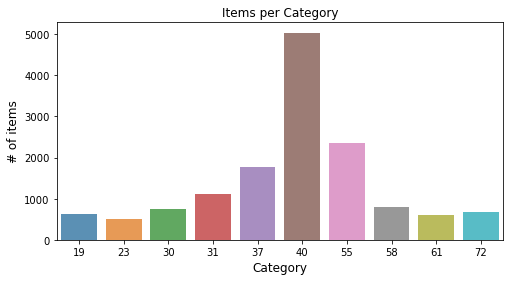

In [7]:
# number of items per cat 
x=item.groupby(['item_category_id']).count()
x=x.sort_values(by='item_id',ascending=False)
x=x.iloc[0:10].reset_index()
x
# #plot
plt.figure(figsize=(8,4))
ax= sns.barplot(x.item_category_id, x.item_id, alpha=0.8)
plt.title("Items per Category")
plt.ylabel('# of items', fontsize=12)
plt.xlabel('Category', fontsize=12)
plt.show()

## Time-series 복습 및 표현

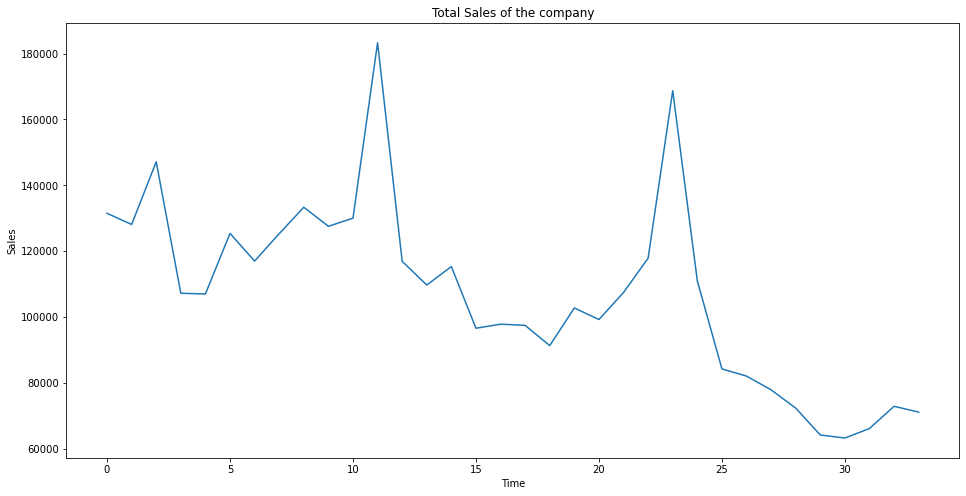

In [8]:
ts=sales.groupby(["date_block_num"])["item_cnt_day"].sum()
ts.astype('float')
plt.figure(figsize=(16,8))
plt.title('Total Sales of the company')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(ts);

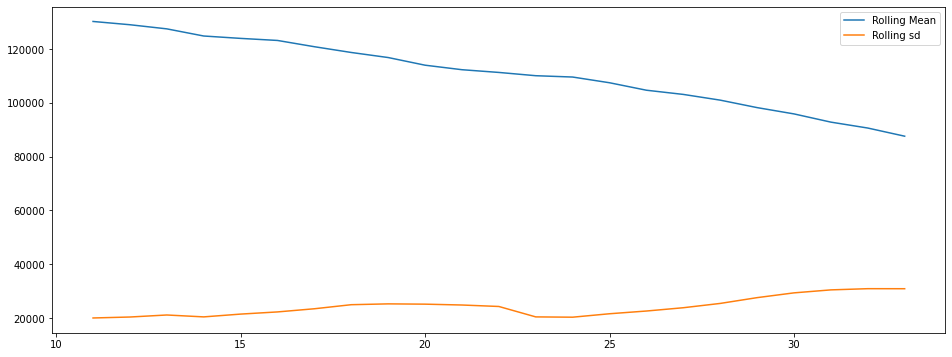

In [9]:
plt.figure(figsize=(16,6))
plt.plot(ts.rolling(window=12,center=False).mean(),label='Rolling Mean')
plt.plot(ts.rolling(window=12,center=False).std(),label='Rolling sd')
plt.legend()

Quick observations: There is an obvious "seasonality" (Eg: peak sales around a time of year) and a decreasing "Trend".

Let's check that with a quick decomposition into Trend, seasonality and residuals.

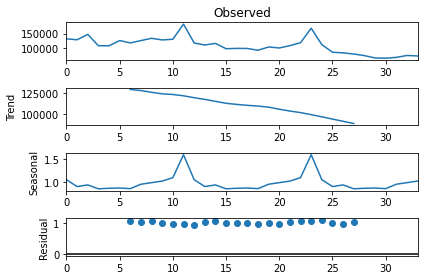

In [10]:
# multiplicative
res = sm.tsa.seasonal_decompose(ts.values,freq=12,model="multiplicative")
#plt.figure(figsize=(16,12))
fig = res.plot()
#fig.show()

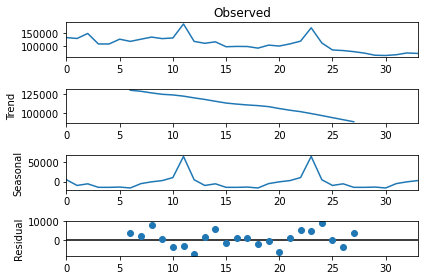

In [11]:
# Additive model
res = sm.tsa.seasonal_decompose(ts.values,freq=12,model="additive")
#plt.figure(figsize=(16,12))
fig = res.plot()
#fig.show()

### Stationarity
=> time-invariance of a series
1. The mean of the series should not be a function of time
2. The variance of the series should not be a function of time (homoscedasticity)
3. The covariance of the i th term and the (i+m)th term should not be a function of time.

There are multiple tests that can be used to check stationarity.

- ADF( Augmented Dicky Fuller Test)
- KPSS
- PP (Phillips-Perron test)

In [12]:
# Stationarity tests
def test_stationarity(timeseries):
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

test_stationarity(ts)

Results of Dickey-Fuller Test:
Test Statistic                 -2.395704
p-value                         0.142953
#Lags Used                      0.000000
Number of Observations Used    33.000000
Critical Value (1%)            -3.646135
Critical Value (5%)            -2.954127
Critical Value (10%)           -2.615968
dtype: float64


In [13]:
# to remove trend
from pandas import Series as Series
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

# invert differenced forecast
def inverse_difference(last_ob, value):
    return value + last_ob

[]

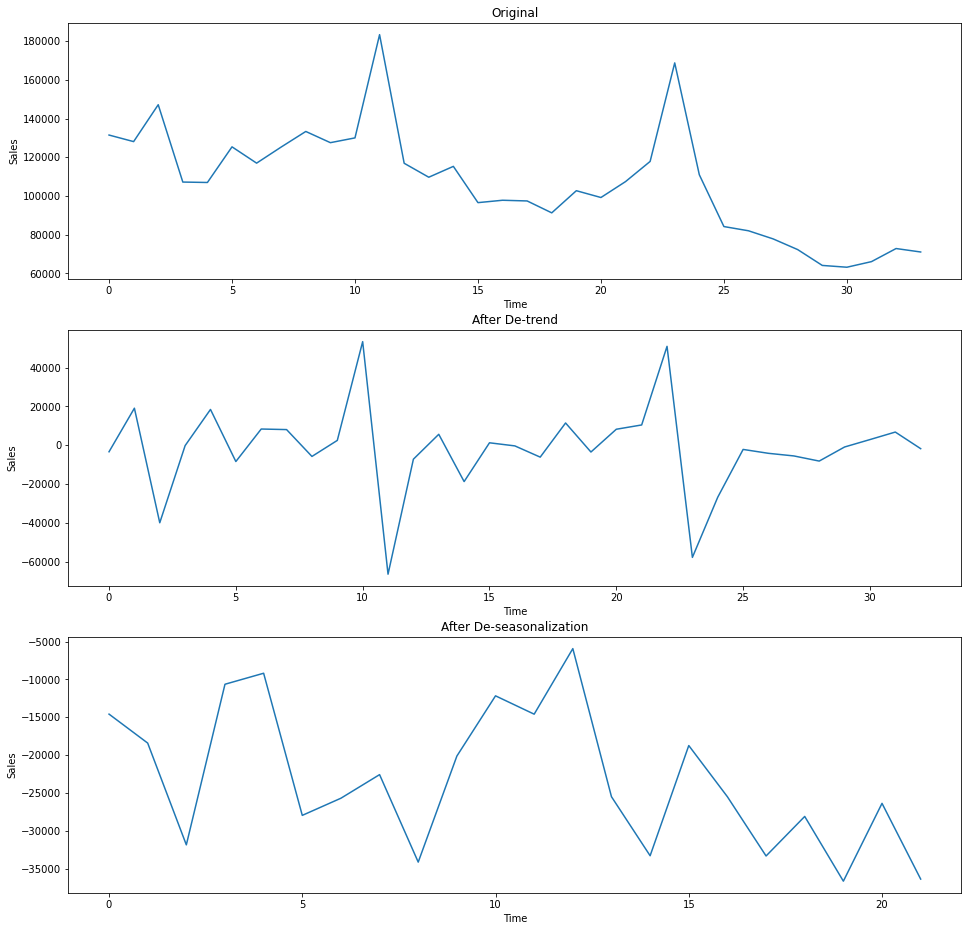

In [14]:
ts.astype('float')
plt.figure(figsize=(16,16))
plt.subplot(311)
plt.title('Original')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(ts)
plt.subplot(312)
plt.title('After De-trend')
plt.xlabel('Time')
plt.ylabel('Sales')
new_ts=difference(ts)
plt.plot(new_ts)
plt.plot()

plt.subplot(313)
plt.title('After De-seasonalization')
plt.xlabel('Time')
plt.ylabel('Sales')
new_ts=difference(ts,12)       # assuming the seasonality is 12 months long
plt.plot(new_ts)
plt.plot()

In [15]:
# now testing the stationarity again after de-seasonality
test_stationarity(new_ts)

Results of Dickey-Fuller Test:
Test Statistic                 -3.270101
p-value                         0.016269
#Lags Used                      0.000000
Number of Observations Used    21.000000
Critical Value (1%)            -3.788386
Critical Value (5%)            -3.013098
Critical Value (10%)           -2.646397
dtype: float64


Now after the transformations, our p-value for the DF test is well within 5 %.   
Hence we can assume Stationarity of the series
We can easily get back the original series using the inverse transform function that we have defined above.

## AR, MA and ARMA models

1. MA - Next value in the series is a function of the average of the previous n number of values
2. AR - The errors(difference in mean) of the next value is a function of the errors in the previous n number of values
3. ARMA - a mixture of both.

### ACF, PACF (복습)
ARIMA 에서 모수 p,d,q는 ACF(Autocorrelation Function)와 PACF(Partial Autocorrelation Function)을 통해 결정할 수 있습니다. ( 물론 적절한 값을 찾기 엄청난 다른 시도들이 있었다. )

- ACF : 시차(lag)에 따른 관측치들 사이의 관련성을 측정하는 함수
- PACF :  다른 관측치의 영향력을 배제하고 두 시차의 관측치 간 관련성을 측정하는 함수

In [16]:
def tsplot(y, lags=None, figsize=(10, 8), style='bmh',title=''):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title(title)
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 

### AR

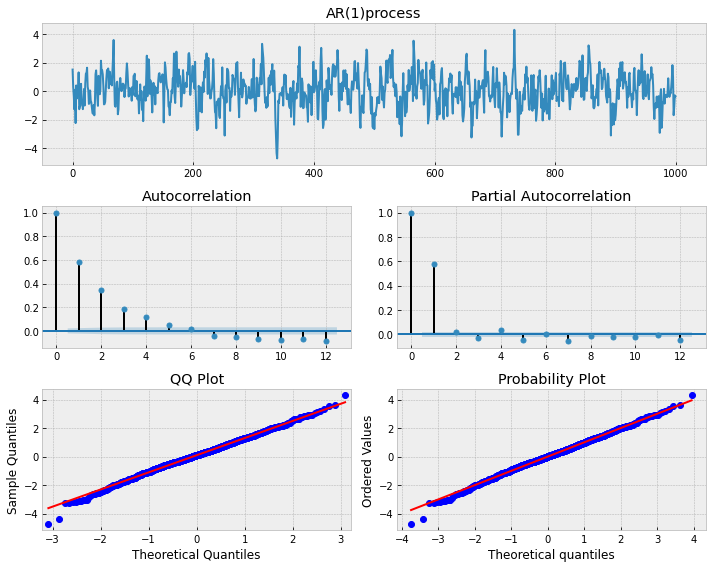

In [17]:
# Simulate an AR(1) process with alpha = 0.6
np.random.seed(1)
n_samples = int(1000)
a = 0.6
x = w = np.random.normal(size=n_samples)

for t in range(n_samples):
    x[t] = a*x[t-1] + w[t]
limit=12    
_ = tsplot(x, lags=limit,title="AR(1)process")

AR(1) process -- has ACF tailing out and PACF cutting off at lag=1

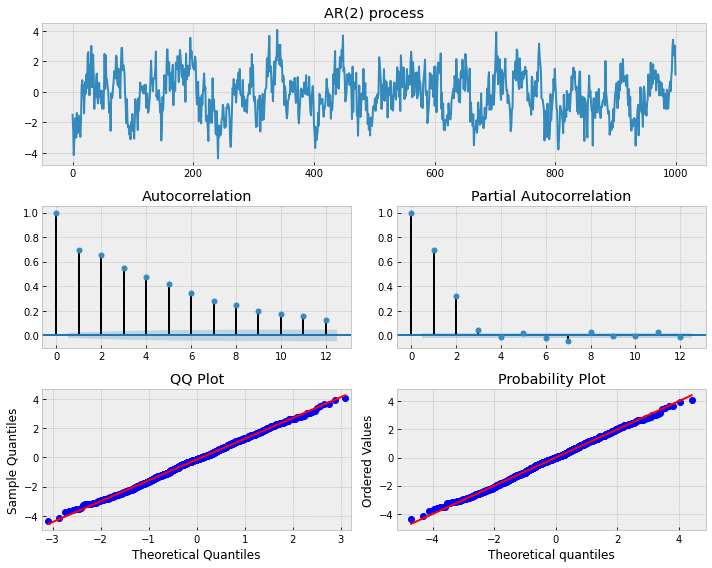

In [34]:
# Simulate an AR(2) process

n = int(1000)
alphas = np.array([.444, .333])
betas = np.array([0.])

# Python requires us to specify the zero-lag value which is 1
# Also note that the alphas for the AR model must be negated
# We also set the betas for the MA equal to 0 for an AR(p) model
# For more information see the examples at statsmodels.org
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

ar2 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n) 
_ = tsplot(ar2, lags=12,title="AR(2) process")

AR(2) process -- has ACF tailing out and PACF cutting off at lag=2

### MA

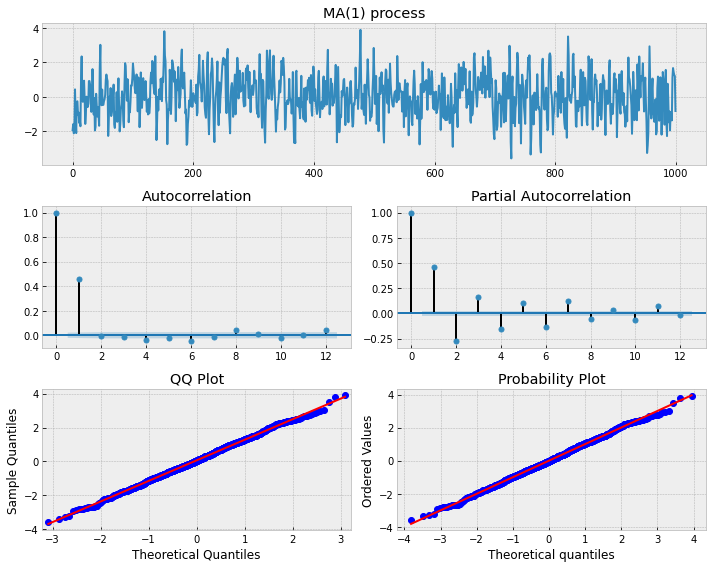

In [35]:
# Simulate an MA(1) process
n = int(1000)
# set the AR(p) alphas equal to 0
alphas = np.array([0.])
betas = np.array([0.8])
# add zero-lag and negate alphas
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]
ma1 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n) 
limit=12
_ = tsplot(ma1, lags=limit,title="MA(1) process")

MA(1) process -- has ACF cut off at lag=1

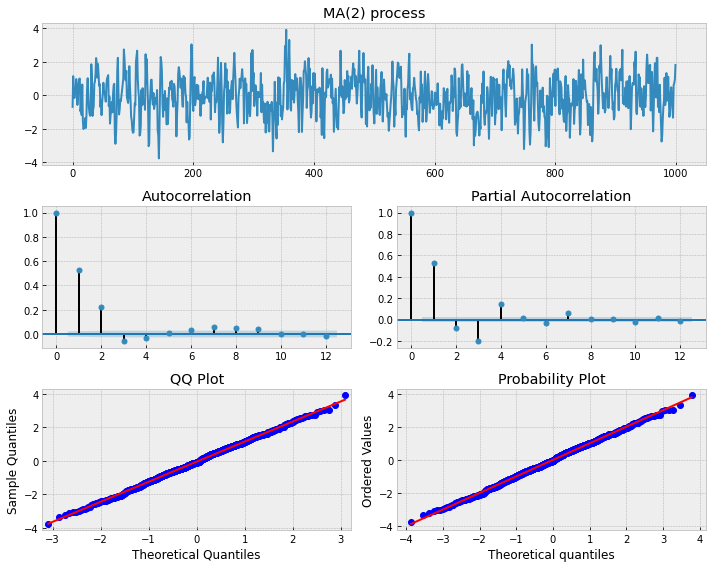

In [36]:
# Simulate MA(2) process with betas 0.6, 0.4
n = int(1000)
alphas = np.array([0.])
betas = np.array([0.6, 0.4])
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

ma3 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n)
_ = tsplot(ma3, lags=12,title="MA(2) process")

MA(2) process -- has ACF cut off at lag=2

### ARMA

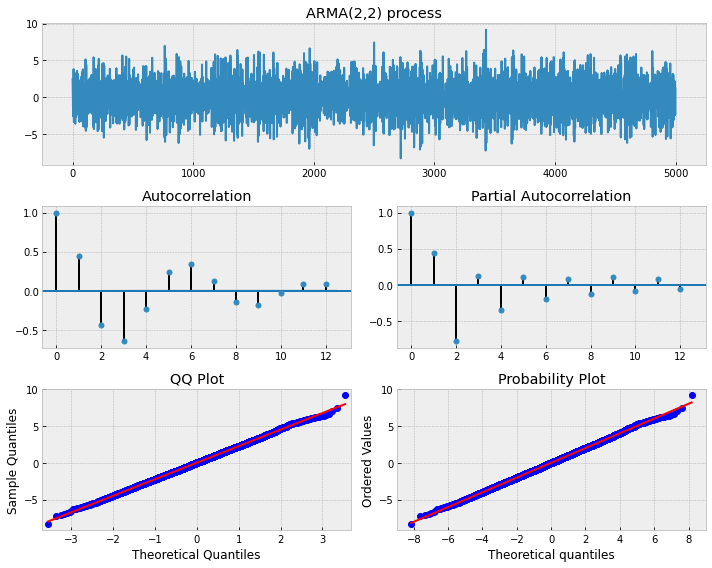

In [37]:
# Simulate an ARMA(2, 2) model with alphas=[0.5,-0.25] and betas=[0.5,-0.3]
max_lag = 12

n = int(5000) # lots of samples to help estimates
burn = int(n/10) # number of samples to discard before fit

alphas = np.array([0.8, -0.65])
betas = np.array([0.5, -0.7])
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

arma22 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n, burnin=burn)
_ = tsplot(arma22, lags=max_lag,title="ARMA(2,2) process")

### Systematic approach to finding the order of AR and MA processes 

In [38]:
# smallest aic value wins
best_aic = np.inf 
best_order = None
best_mdl = None

rng = range(5)
for i in rng:
    for j in rng:
        try:
            tmp_mdl = smt.ARMA(arma22, order=(i, j)).fit(method='mle', trend='nc')
            tmp_aic = tmp_mdl.aic
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (i, j)
                best_mdl = tmp_mdl
        except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

aic: 15187.57912 | order: (2, 2)


ARMA(2,2) 가 맞다.   
time-series 데이터에 해보자

In [39]:
#
# pick best order by aic 
# smallest aic value wins
best_aic = np.inf 
best_order = None
best_mdl = None

rng = range(5)
for i in rng:
    for j in rng:
        try:
            tmp_mdl = smt.ARMA(new_ts.values, order=(i, j)).fit(method='mle', trend='nc')
            tmp_aic = tmp_mdl.aic
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (i, j)
                best_mdl = tmp_mdl
        except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

aic: 472.99703 | order: (1, 1)


In [40]:
# Simply use best_mdl.predict() to predict the next values

# adding the dates to the Time-series as index
ts=sales.groupby(["date_block_num"])["item_cnt_day"].sum()
ts.index=pd.date_range(start = '2013-01-01',end='2015-10-01', freq = 'MS')
ts=ts.reset_index()
ts.head()

index  item_cnt_day
0 2013-01-01      131479.0
1 2013-02-01      128090.0
2 2013-03-01      147142.0
3 2013-04-01      107190.0
4 2013-05-01      106970.0

### Prophet
Recently open-sourced by Facebook research. It's a very promising tool, that is often a very handy and quick solution to the frustrating flatline.

적절한 데이터 전처리나 파라미터 튜닝을 잘 해서 flatline 의 결과가 나오지 않도록 할 수 있지만... 대부분은 그렇게 할 수 있는 전문성이나 인내심이 없기때문에!   
아무튼 좋음

In [41]:
from fbprophet import Prophet
#prophet reqiures a pandas df at the below config 
# ( date column named as DS and the value column as Y)
ts.columns=['ds','y']
model = Prophet( yearly_seasonality=True) #instantiate Prophet with only yearly seasonality as our data is monthly 
model.fit(ts) #fit the model with your dataframe

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [42]:
# predict for five months in the furure and MS - month start is the frequency
future = model.make_future_dataframe(periods = 5, freq = 'MS')  
# now lets make the forecasts
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds           yhat     yhat_lower     yhat_upper
34 2015-11-01   83193.957416   80031.505974   86383.442551
35 2015-12-01  125513.063181  122345.111922  128691.013345
36 2016-01-01   75625.688717   72576.604667   78952.115424
37 2016-02-01   40109.144632   36786.276698   43426.847176
38 2016-03-01   76664.084927   73528.805307   79929.642744

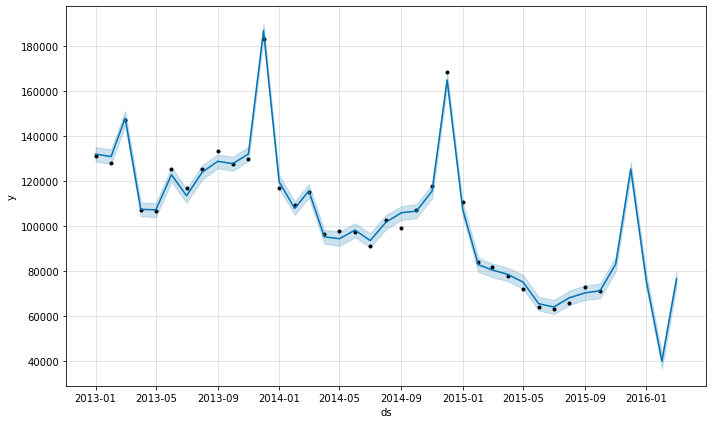

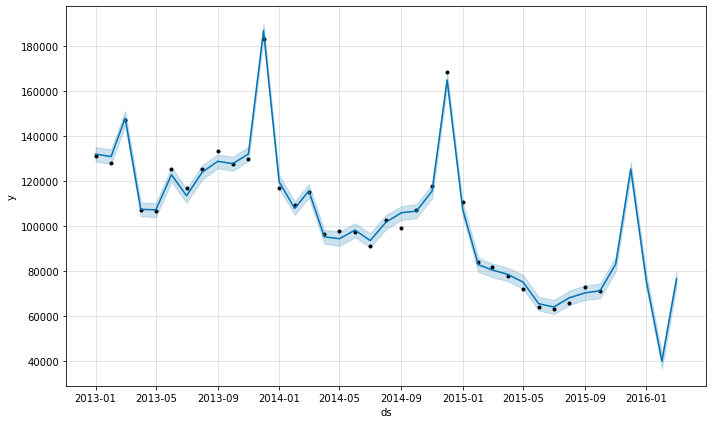

In [43]:
model.plot(forecast)

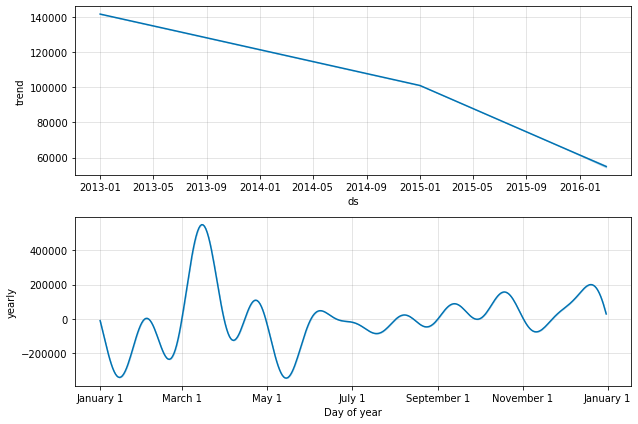

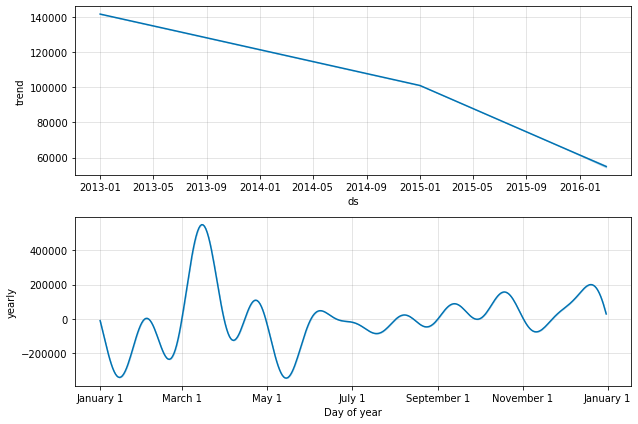

In [44]:
model.plot_components(forecast)

Awesome. The trend and seasonality from Prophet look similar to the ones that we had earlier using the traditional methods.

## UCM ( Unobserved Components Model )

 The intuition here is similar to that of the prophet. The model breaks down the time-series into its components, trend, seasonal, cycle and regresses them and then predicts the next point for the components and then combines them.
 => 파이썬에 쓸만한 패키지가 없다고 함... 그냥 이런거 있다고 알아만 두는걸로!
 
 

## Hierarchical time series

### Bottom up approach
- Predict all the base level series using any method, and then just aggregate it to the top.
- Advantages: Simple , No information is lost due to aggregation.
- Dis-advantages: Lower levels can be noisy
- 요소 하나하나 다 활용 후 합치기. 단, 노이즈 가능성

### Top down approach
- Predict the top level first. (Eg: predict total sales first)
- Then calculate weights that denote the proportion of the total sales that needs to be given to the base level forecast(Eg:) the contribution of the item's sales to the total sales
- There are different ways of arriving at the "weights".
    - Average Historical Proportions - Simple average of the item's contribution to sales in the past months
    - Proportion of historical averages - Weight is the ratio of average value of bottom series by the average value of total series (Eg: Weight(item1)= mean(item1)/mean(total_sales))
    - Forecasted Proportions - Predict the proportion in the future using changes in the past proportions
- Use these weights to calcuate the base -forecasts and other levels
- 원하는 결과 대상으로 먼저 예측하고 각 항목의 결과 대상에 대한 가중치를 계산

### Middle out:
- Use both bottom up and top down together.
- Eg: Consider our problem of predicting store-item level forecasts.
    - Take the middle level(Stores) and find forecasts for the stores
    - Use bottoms up approach to find overall sales
    - Dis-integrate store sales using proportions to find the item-level sales using a top-down approach
- 위에 두 방법(bottom up, top down) 둘 다 사용

### Optimal combination approach

- Predict for all the layers independently
- Since, all the layers are independent, they might not be consistent with hierarchy
    - Eg: Since the items are forecasted independently, the sum of the items sold in the store might not be equal to the forecasted sale of store or as Hyndman puts it “aggregate consistent”
- Then some matrix calculations and adjustments happen to provide ad-hoc adjustments to the forecast to make them consistent with the hierarchy
- 각 층 독립적 예측


In [45]:
total_sales=sales.groupby(['date_block_num'])["item_cnt_day"].sum()
dates=pd.date_range(start = '2013-01-01',end='2015-10-01', freq = 'MS')

total_sales.index=dates
total_sales.head()

2013-01-01    131479.0
2013-02-01    128090.0
2013-03-01    147142.0
2013-04-01    107190.0
2013-05-01    106970.0
Freq: MS, Name: item_cnt_day, dtype: float64

In [46]:
# get the unique combinations of item-store from the sales data at monthly level
monthly_sales=sales.groupby(["shop_id","item_id","date_block_num"])["item_cnt_day"].sum()
# arrange it conviniently to perform the hts 
monthly_sales=monthly_sales.unstack(level=-1).fillna(0)
monthly_sales=monthly_sales.T
dates=pd.date_range(start = '2013-01-01',end='2015-10-01', freq = 'MS')
monthly_sales.index=dates
monthly_sales=monthly_sales.reset_index()
monthly_sales.head()

shop_id      index     0                                             ...  \
item_id               30    31    32   33    35   36   40   42   43  ...   
0       2013-01-01   0.0   0.0   6.0  3.0   1.0  0.0  0.0  0.0  1.0  ...   
1       2013-02-01  31.0  11.0  10.0  3.0  14.0  1.0  1.0  1.0  0.0  ...   
2       2013-03-01   0.0   0.0   0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...   
3       2013-04-01   0.0   0.0   0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...   
4       2013-05-01   0.0   0.0   0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...   

shop_id    59                                                        
item_id 22144 22145 22150 22151 22153 22154 22155 22162 22164 22167  
0         0.0   0.0   0.0   2.0   0.0   1.0   0.0   0.0   0.0   0.0  
1         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
2         0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0  
3         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
4         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  

[5 rows x 424125 columns]

### Bottom up?

In [47]:
import time
start_time=time.time()

# Bottoms up
# Calculating the base forecasts using prophet
# From HTSprophet pachage -- https://github.com/CollinRooney12/htsprophet/blob/master/htsprophet/hts.py
forecastsDict = {}
for node in range(len(monthly_sales)):
    # take the date-column and the col to be forecasted
    nodeToForecast = pd.concat([monthly_sales.iloc[:,0], monthly_sales.iloc[:, node+1]], axis = 1)
    #print(nodeToForecast.head())  # just to check
# rename for prophet compatability

# 이렇게 하면 오류나더라...? 그래서 그냥 아래처럼 단순히 column 이름 변경

    # nodeToForecast = nodeToForecast.rename(columns = {nodeToForecast.columns[0] : 'ds'})
    # nodeToForecast = nodeToForecast.rename(columns = {nodeToForecast.columns[1] : 'y'})

    nodeToForecast.columns = ['ds','y']
    # print(type(nodeToForecast))
    # print(nodeToForecast.head())  # just to check
    growth = 'linear'
    m = Prophet(growth, yearly_seasonality=True)
    m.fit(nodeToForecast)
    future = m.make_future_dataframe(periods = 1, freq = 'MS')
    forecastsDict[node] = m.predict(future)
    if (node== 10):
        end_time=time.time()
        print("forecasting for ",node,"th node and took",end_time-start_time,"s")
        break

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

10개 하는데 16초정도 걸리네... 시간이 너무 오래걸린다!

### Middle Out

In [48]:
monthly_shop_sales=sales.groupby(["date_block_num","shop_id"])["item_cnt_day"].sum()
# get the shops to the columns
monthly_shop_sales=monthly_shop_sales.unstack(level=1)
monthly_shop_sales=monthly_shop_sales.fillna(0)
monthly_shop_sales.index=dates
monthly_shop_sales=monthly_shop_sales.reset_index()
monthly_shop_sales.head()

shop_id      index       0       1       2      3       4       5       6  \
0       2013-01-01  5578.0  2947.0  1146.0  767.0  2114.0     0.0  3686.0   
1       2013-02-01  6127.0  3364.0   488.0  798.0  2025.0   877.0  4007.0   
2       2013-03-01     0.0     0.0   753.0  959.0  2060.0  1355.0  4519.0   
3       2013-04-01     0.0     0.0   583.0  647.0   285.0  1008.0  3168.0   
4       2013-05-01     0.0     0.0   553.0  710.0  1211.0  1110.0  3022.0   

shop_id       7       8  ...      50      51      52      53      54     55  \
0        2495.0  1463.0  ...  3406.0  2748.0  1812.0  2055.0  9386.0    0.0   
1        2513.0  1156.0  ...  3054.0  2284.0  1737.0  1906.0  8075.0    0.0   
2        2460.0   977.0  ...  3610.0  2605.0  2034.0  2365.0  9488.0    0.0   
3        1540.0    -1.0  ...  2740.0  1945.0  1446.0  1515.0  6726.0    0.0   
4        1647.0     0.0  ...  2839.0  2243.0  1482.0  1767.0  7006.0  852.0   

shop_id      56      57      58      59  
0        3238.0     0.0     0.0  2017.0  
1        2655.0     0.0     0.0  1897.0  
2        3099.0  6586.0  3773.0  2028.0  
3        2153.0  5493.0  2831.0  1388.0  
4        2140.0  5233.0  2308.0  1374.0  

[5 rows x 61 columns]

In [49]:
start_time=time.time()

# Calculating the base forecasts using prophet
# From HTSprophet pachage -- https://github.com/CollinRooney12/htsprophet/blob/master/htsprophet/hts.py
forecastsDict = {}
for node in range(len(monthly_shop_sales)):
    # take the date-column and the col to be forecasted
    nodeToForecast = pd.concat([monthly_shop_sales.iloc[:,0], monthly_shop_sales.iloc[:, node+1]], axis = 1)
#     print(nodeToForecast.head())  # just to check
# rename for prophet compatability
    nodeToForecast = nodeToForecast.rename(columns = {nodeToForecast.columns[0] : 'ds'})
    nodeToForecast = nodeToForecast.rename(columns = {nodeToForecast.columns[1] : 'y'})
    growth = 'linear'
    m = Prophet(growth, yearly_seasonality=True)
    m.fit(nodeToForecast)
    future = m.make_future_dataframe(periods = 1, freq = 'MS')
    forecastsDict[node] = m.predict(future)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

In [50]:
#predictions = np.zeros([len(forecastsDict[0].yhat),1]) 
nCols = len(list(forecastsDict.keys()))+1
for key in range(0, nCols-1):
    f1 = np.array(forecastsDict[key].yhat)
    f2 = f1[:, np.newaxis]
    if key==0:
        predictions=f2.copy()
       # print(predictions.shape)
    else:
       predictions = np.concatenate((predictions, f2), axis = 1)

In [55]:
predictions_unknown=predictions[-1]
print(predictions_unknown)
print('====')
print(predictions.shape, predictions)

[  240.81393204   116.28589275  1107.78682599   888.86026388
  1465.17303431  1311.88427115  2553.96936873  1874.98195159
  -103.61300882   581.58037786   706.7584699     29.36442879
  3684.86252823  -533.01327161  1125.91098768  2102.61611136
  1235.63309739  1620.531595    1507.99916018  1901.9932538
  -681.46090572  2090.00319908  1744.75630904  -742.48402473
  2329.36463879  6642.37729189  1533.46139986  6841.03565345
  4470.31106098   145.57284766   296.75210806  8209.01135323
 -1266.81428446   775.5725287 ]
====
(35, 34) [[ 3912.1172607   2060.5802157   1130.00816966 ... 10282.21200416
    867.58957906    77.47232577]
 [ 4145.88932982  2285.42705108   593.18110631 ... 11291.70415255
    867.20631104    97.1541893 ]
 [ -770.84704307  -417.69087448   833.8406432  ... 12564.01608055
   1123.1500079     32.34518262]
 ...
 [ -654.27382642  -358.86278569   819.06569082 ...  6496.44450822
   -390.49734494   297.58922869]
 [ -355.70165466  -197.86070791   743.39551828 ...  6184.11961849


여기까지가 store level prediction인거지?